In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 設定 data_path
dir_data = '../../Data/Part01/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:                                               # 直接讀columns，不用 app_train.columns
#     print(col)
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])                                  # fit 辨識多少label，transform以這規則去轉換
            # Transform both training and testing data
#             print('original app_train :', col, '\n', app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
#             print('app_train :', col, '\n', app_train[col])
           # Keep track of how many columns were label encoded
            le_count += 1
print('original app_train :', '\n', app_train.shape)   
# print('original app_train :', '\n', app_train.head()) 
app_train = pd.get_dummies(app_train)
print('one_hot app_train :', '\n', app_train.shape) 
# print('app_train :', '\n', app_train.head())
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
print('ANOM app_train :', '\n', app_train.shape) 
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

original app_train : 
 (307511, 122)
one_hot app_train : 
 (307511, 243)
ANOM app_train : 
 (307511, 244)


### 相關係數
一樣，pandas 很貼心地讓我們可以非常容易計算相關係數

In [3]:
TARGET_corr = app_train.corr()['TARGET']
TARGET_corr 

SK_ID_CURR                                 -0.002108
TARGET                                      1.000000
NAME_CONTRACT_TYPE                         -0.030896
FLAG_OWN_CAR                               -0.021851
FLAG_OWN_REALTY                            -0.006148
CNT_CHILDREN                                0.019187
AMT_INCOME_TOTAL                           -0.003982
AMT_CREDIT                                 -0.030369
AMT_ANNUITY                                -0.012817
AMT_GOODS_PRICE                            -0.039645
REGION_POPULATION_RELATIVE                 -0.037227
DAYS_BIRTH                                 -0.078239
DAYS_EMPLOYED                               0.074958
DAYS_REGISTRATION                           0.041975
DAYS_ID_PUBLISH                             0.051457
OWN_CAR_AGE                                 0.037612
FLAG_MOBIL                                  0.000534
FLAG_EMP_PHONE                              0.045982
FLAG_WORK_PHONE                             0.

In [4]:
# app_train.corr()

## 練習時間
列出目標 (TARGET) 與所有欄位之間相關係數，數值最大以及最小各 15 個

通過相關係數的結果觀察有興趣的欄位與 TARGET 或其他欄位的相關係數，並嘗試找出有趣的訊息
- 最好的方式當然是畫圖，舉例來說，我們知道  EXT_SOURCE_3 這個欄位和 TARGET 之間的相關係數是 -0.178919 (在已經這個資料集已經是最負的了！)，那我們可以 EXT_SOURCE_3  為 x 軸， TARGET 為 y 軸，把資料給畫出來

In [5]:
Corr_First15 = TARGET_corr.sort_values(ascending=False)[0:16]
Corr_last15 = TARGET_corr.sort_values(ascending=True)[0:15]
print('correlation coefficient first 15 :', '\n', Corr_First15, '\n')
print('correlation coefficient last 15 :', '\n', Corr_last15, '\n')

correlation coefficient first 15 : 
 TARGET                                               1.000000
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
OWN_CAR_AGE                      

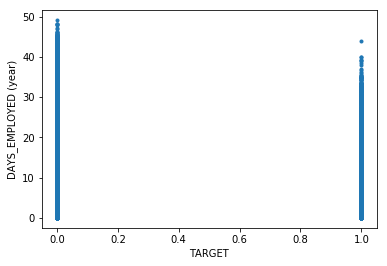

Correlation: 0.0750


In [6]:
# 如果直接畫散布圖 - 看不出任何趨勢或形態
plt.plot(app_train[Corr_First15.index[0]], app_train[Corr_First15.index[1]] /(-365), '.')
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_First15.index[1] + ' (year)')
plt.show()
print("Correlation: %.4f" % (Corr_First15[1]))

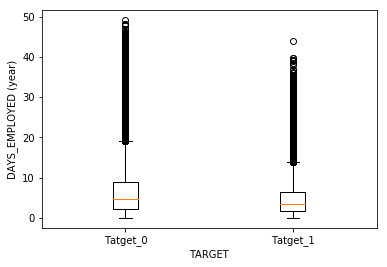

In [7]:
#DAYS_EMPLOYED
app_train_nonan = app_train[~app_train[Corr_First15.index[1]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_First15.index[1]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_First15.index[1]]

plt.boxplot((Tatget_0 /(-365),Tatget_1 /(-365)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_First15.index[1] +' (year)')
plt.show()
#可以觀察到工作時間越短，需要貸款的人數越高。工作時間長短與財務困難似乎無關

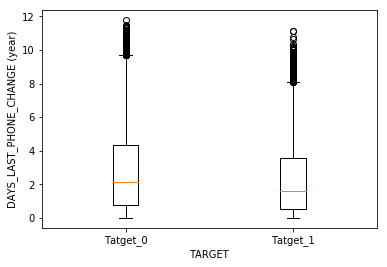

In [8]:
#DAYS_LAST_PHONE_CHANGE
app_train_nonan = app_train[~app_train[Corr_First15.index[5]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_First15.index[5]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_First15.index[5]]

plt.boxplot((Tatget_0 /(-365),Tatget_1 /(-365)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_First15.index[5] +' (year)')
plt.show()
#可以觀察到常換電話，需要貸款的人數越高。

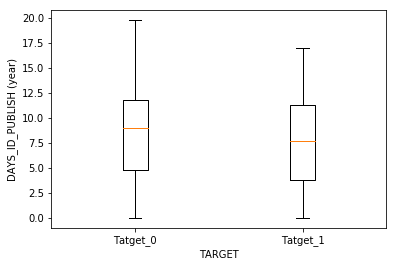

In [9]:
#DAYS_ID_PUBLISH
app_train_nonan = app_train[~app_train[Corr_First15.index[7]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_First15.index[7]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_First15.index[7]]

plt.boxplot((Tatget_0 /(-365),Tatget_1 /(-365)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_First15.index[7] +' (year)')
plt.show()

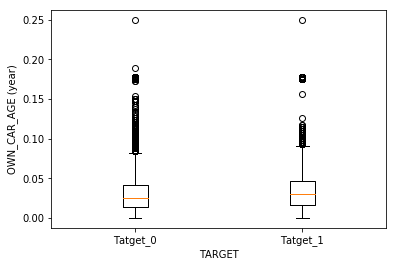

In [10]:
#OWN_CAR_AGE
app_train_nonan = app_train[~app_train[Corr_First15.index[15]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_First15.index[15]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_First15.index[15]]

plt.boxplot((Tatget_0 /(365),Tatget_1 /(365)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_First15.index[15] +' (year)')
plt.show()
#可以觀察到買車時間越近，需要貸款的人數越高。

Text(0, 0.5, 'EXT_SOURCE_3')

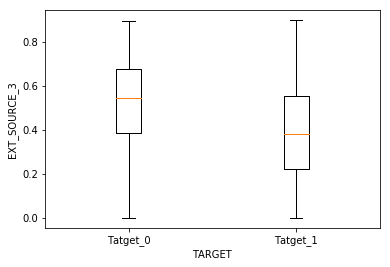

In [11]:
#EXT_SOURCE_3
app_train_nonan = app_train[~app_train[Corr_last15.index[0]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_last15.index[0]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_last15.index[0]]

plt.boxplot((Tatget_0,Tatget_1),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_last15.index[0])
#不知道外部數據來源

Text(0, 0.5, 'DAYS_BIRTH')

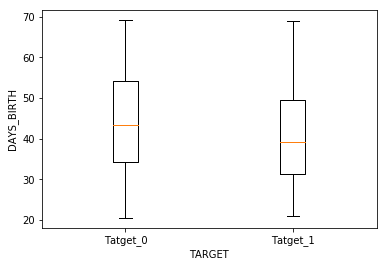

In [12]:
#DAYS_BIRTH
app_train_nonan = app_train[~app_train[Corr_last15.index[3]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_last15.index[3]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_last15.index[3]]

plt.boxplot((Tatget_0 /(365),Tatget_1 /(365)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_last15.index[3])

Text(0, 0.5, 'FLOORSMAX_AVG')

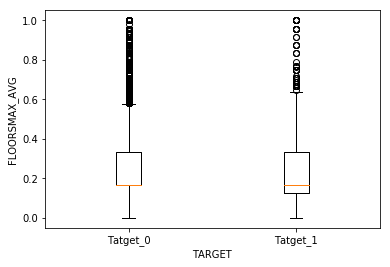

In [13]:
#FLOORSMAX_AVG
app_train_nonan = app_train[~app_train[Corr_last15.index[9]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_last15.index[9]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_last15.index[9]]

plt.boxplot((Tatget_0, Tatget_1),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_last15.index[9])

Text(0, 0.5, 'AMT_GOODS_PRICE (value_log)')

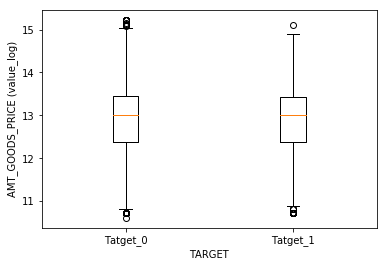

In [14]:
#FLOORSMAX_AVG
app_train_nonan = app_train[~app_train[Corr_last15.index[14]].isnull()]
Tatget_0 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==0][Corr_last15.index[14]]
Tatget_1 = app_train_nonan[app_train_nonan[Corr_First15.index[0]]==1][Corr_last15.index[14]]

plt.boxplot((np.log(Tatget_0), np.log(Tatget_1)),labels=('Tatget_0','Tatget_1'))
plt.xlabel(Corr_First15.index[0])
plt.ylabel(Corr_last15.index[14] + ' (value_log)')